## Exploration of DeepLiftSHAP with binary MNIST

**Function        : Exploration of DeepLiftSHAP with binary MNIST**<br>
**Author          : Team DIANNA**<br>
**Contributor     :**<br>
**First Built     : 2021.06.30**<br>
**Last Update     : 2021.07.06**<br>
**Library         : os, numpy, matplotlib, torch, captum**<br>
**Description     : In this notebook we test XAI method DeepLiftSHAP using trained binary MNIST model.**<br>
**Return Values   : Shapley scores**<br>
**Note**          : We use Captum library to perform DeepLiftSHAP. This library works only with pytorch and it is not compitable with onnx.<br>

In [1]:
%matplotlib inline
import os
import time as tt
import numpy as np
# DL framework
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
#import torch.onnx
# XAI framework
from captum.attr import DeepLift
from captum.attr import DeepLiftShap
from captum.attr import visualization as viz
# for plotting
import matplotlib.pyplot as plt
# report and monitoring with Weights & Biases

### Path to the dataset and the model

In [2]:
# please specify data path
datapath = '/mnt/d/NLeSC/DIANNA/data/mnist/binary-MNIST'
# please specify model path
model_path = '/mnt/d/NLeSC/DIANNA/codebase/dianna/example_data/model_generation/MNIST'
# please specify output path
output_path = '/mnt/d/NLeSC/DIANNA/codebase/dianna/example_data/xai_method_study'
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok = True)

### Load data (binary MNIST)

In [3]:
# load binary MNIST from local
# load data
fd = np.load(os.path.join(datapath, 'binary-mnist.npz'))
# training set
train_X = fd['X_train']
train_y = fd['y_train']
# testing set
test_X = fd['X_test']
test_y = fd['y_test']
fd.close()

# dimensions of data
print("dimensions of mnist:")
print("dimensions or training set", train_X.shape)
print("dimensions or training set label", train_y.shape)
print("dimensions or testing set", test_X.shape)
print("dimensions or testing set label", test_y.shape)
# statistics of training set
print("statistics of training set:")
print("Digits: 0 1")
print("labels: {}".format(np.unique(train_y)))
print("Class distribution: {}".format(np.bincount(train_y)))
print("Labels of training set", train_y[:20])

dimensions of mnist:
dimensions or training set (12665, 784)
dimensions or training set label (12665,)
dimensions or testing set (2115, 784)
dimensions or testing set label (2115,)
statistics of training set:
Digits: 0 1
labels: [0 1]
Class distribution: [5923 6742]
Labels of training set [0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1]


### Prepare data as torch tensor

In [4]:
# use pytorch data loader
test_X_torch = torch.from_numpy(test_X).type(torch.FloatTensor)
test_y_torch = torch.from_numpy(test_y).type(torch.LongTensor)
# reshape the input following the definition in pytorch (batch, channel, Height, Width)
test_X_torch = test_X_torch.view(-1,1,28,28)

### Load model (Pytorch model trained for binary MNIST)

In [5]:
# define the model first
class MnistNet(nn.Module):
    def __init__(self, kernels=[16, 32], dropout = 0.1, classes=2):
        '''
        Two layer CNN model with max pooling.
        '''
        super(MnistNet, self).__init__()
        self.kernels = kernels
        # 1st layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout()
        )
        # 2nd layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout()
        )
        self.fc1 = nn.Linear(7 * 7 * kernels[-1], kernels[-1]) # pixel 28 / maxpooling 2 * 2 = 7
        self.fc2 = nn.Linear(kernels[-1], classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# hyper-parameters
kernels = [16, 32]
dropout = 0.5
classes = 2
# create model
model = MnistNet(kernels, dropout, classes)
# load whole model state
checkpoint = torch.load(os.path.join(model_path, 'mnistnet_training_checkpoint.pt'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Predict the class of the input image <br>

In [6]:
# check the prediction
model.eval()

# overall test accuracy
correct = 0
for i in range(len(test_X_torch)):
    output = model(test_X_torch[i:i+1,:,:,:])
    predicted = torch.max(output,1)[1]
    correct += (predicted == test_y[i]).sum()

print("Test accuracy:{:.3f}% ".format(float(correct*100) / float(len(test_X_torch))))

# check one case
output = model(test_X_torch[:1,:,:,:])
predicted = torch.max(output,1)[1]
print("prediction", predicted)
print("ground truth", test_y[0])

Test accuracy:99.905% 
prediction tensor([1])
ground truth 1


### DeepLIFT-based attribution <br>
Compute attributions using DeepLIFT and visualize them on the image. <br>
The attribution scores are normalized. Positive score indicates the corresponding pixel/super-pixel push the prediction to the positive side from the reference state (baseline), and vise versa.<br>

/home/yangliu/miniconda3/lib/python3.8/site-packages/captum/_utils/gradient.py:53: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/yangliu/miniconda3/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


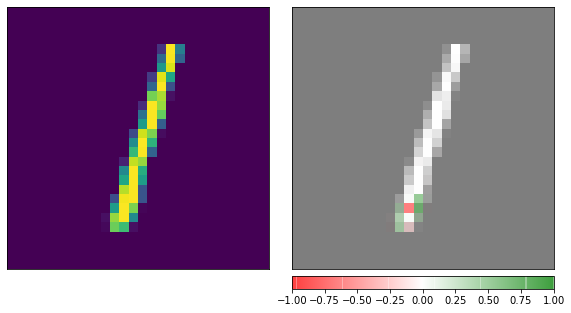

In [7]:
deeplift = DeepLift(model)
# zero out the first figure as the baseline
attributions_dl = deeplift.attribute(test_X_torch[:1,:,:,:],
                                     baselines=test_X_torch[:1,:,:,:] * 0,
                                     target=test_y_torch[0])
# display attraibution map
# _ = viz.visualize_image_attr(np.transpose(attributions_dl[0,:,:,:].cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(test_X_torch[0,:,:,:].cpu().detach().numpy(), (1,2,0)),
#                                       method='blended_heat_map', sign="all", show_colorbar=True)
# display attraibution map alongside with the predictand
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_dl[0,:,:,:].cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(test_X_torch[0,:,:,:].cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "all"], #absolute_value
                                      show_colorbar=True)

### Compute DeepLifttShap
Compute Shapley score based on the DeepLift algorithm. <br>


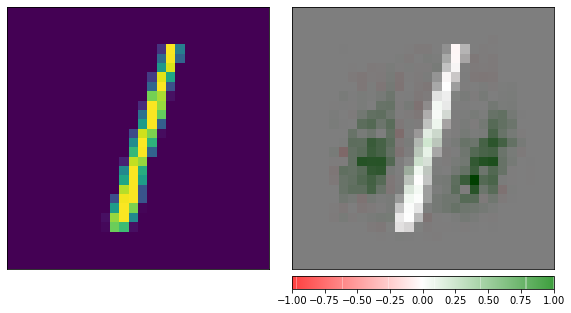

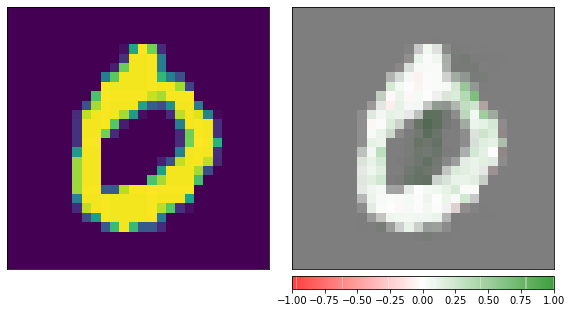

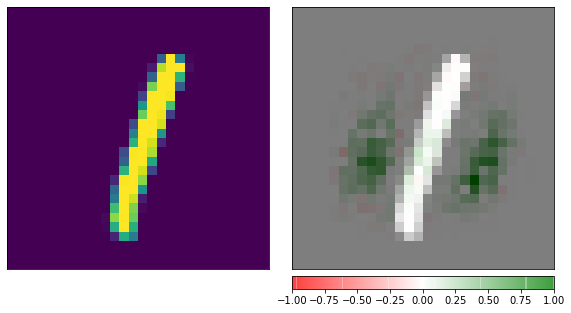

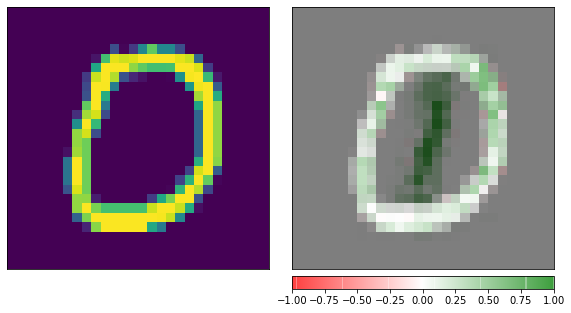

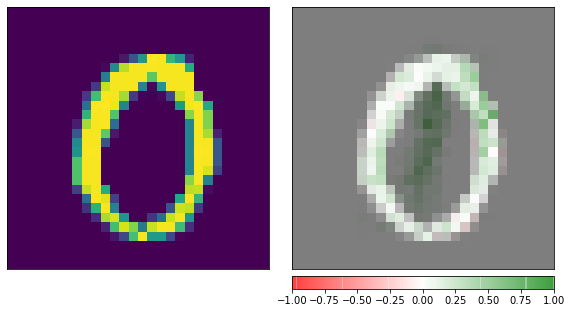

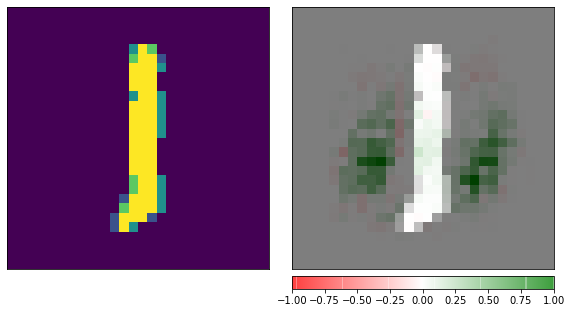

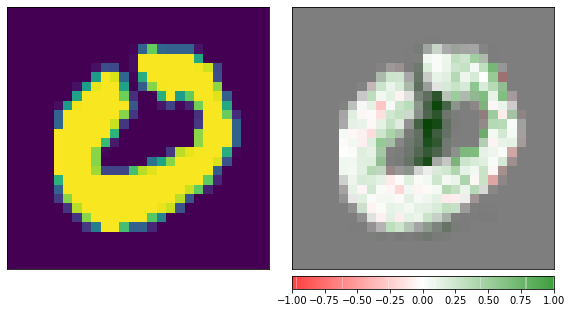

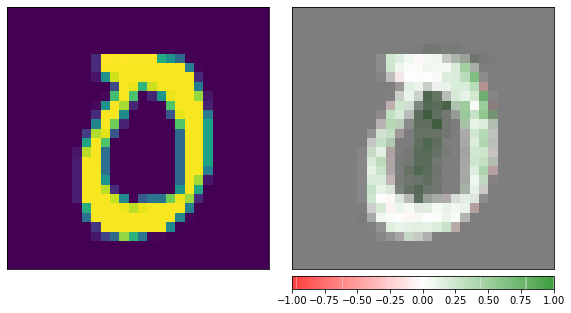

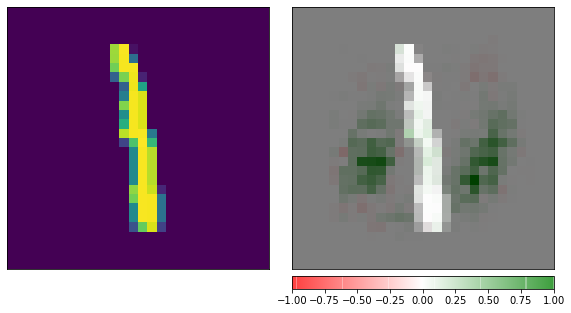

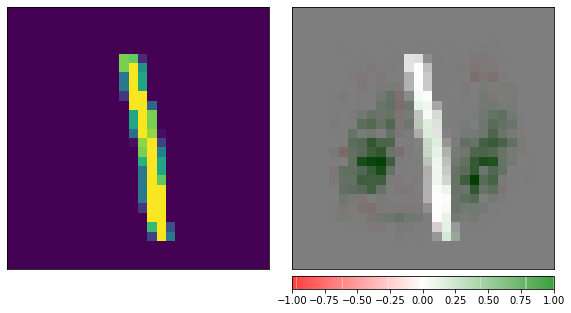

In [8]:
torch.manual_seed(0)
np.random.seed(0)

deeplift_shap = DeepLiftShap(model)

# Defining baseline distribution of images
#rand_img_dist = torch.cat([test_X_torch[:1,:,:,:] * 0, test_X_torch[:1,:,:,:] * 1])
rand_img_dist = test_X_torch[np.random.choice(test_X_torch.shape[0], 100, replace=False)]
# plot the attribution for a number of cases
case = 10
for i in range(case):
    
    attributions_dlsh = deeplift_shap.attribute(test_X_torch[i:i+1,:,:,:],
                                     baselines=rand_img_dist,
                                     target=test_y_torch[i])
    # display attraibution map
    #_ = viz.visualize_image_attr(np.transpose(attributions_dlsh[0,:,:,:].cpu().detach().numpy(), (1,2,0)),
    #                             np.transpose(test_X_torch[0,:,:,:].cpu().detach().numpy(), (1,2,0)),
    #                             method='blended_heat_map', sign="all", show_colorbar=True)
    # display attraibution map alongside with the predictand
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_dlsh[0,:,:,:].cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(test_X_torch[i,:,:,:].cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "blended_heat_map"],
                                          ["all", "all"], #absolute_value
                                          show_colorbar=True)    